# Exploring Logistic Regression

In this post I will explore logistic regression, a technique used to predict class membership given some set of parameters. The method of exploration will be though an example, in which I will building a classifier to predecit candidate acceptance into ML University (fictional) given their performance on two entrance exam scores.

For the sake of brevity I will leave testing of goodness, and regularization for a future post.

# Getting to know ML Universities Admittance and Exam  Data

Usually the first step in the analysis process is to get familiarized with the format and integrety of the data. In this case the data is already well csv (comma separated value) format, and I know before hand that the first two columns contain the first and second exam scores, and the third column contains the applicants admittance (yes=1, no=0). So the first step will be to read in the data, and list the some summary statistics.

It is worth noting that the first step would actually be to look at the raw data file to determinie what format it is in, and what data types should be used for each column. In this case I know the data format before hand, so I have skipped this step.

In [2]:
# Numeric
import numpy as np
import pandas as pd

#Stats & ML
import sklearn.linear_model as linear_model
import scipy.optimize as opt
from scipy.stats import logistic
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")
sns.set_style("darkgrid")

In [3]:
data = pd.read_csv('ex2data1.txt', header=None, names=['exam1', 'exam2', 'admittance'])

In [4]:
data.describe()

,exam1,exam2,admittance
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


## Observations from the inital inspection

From the summary statistics we can see that:
- The data set contains 100 records.
- The minimum and maximum scores for both tests are bounded by [30, 100].
- The mean and standard deviation are close in value for both exams.

The next step will be to plot the data to determining if a linear classifier is appropriate for classifing this dataset. 

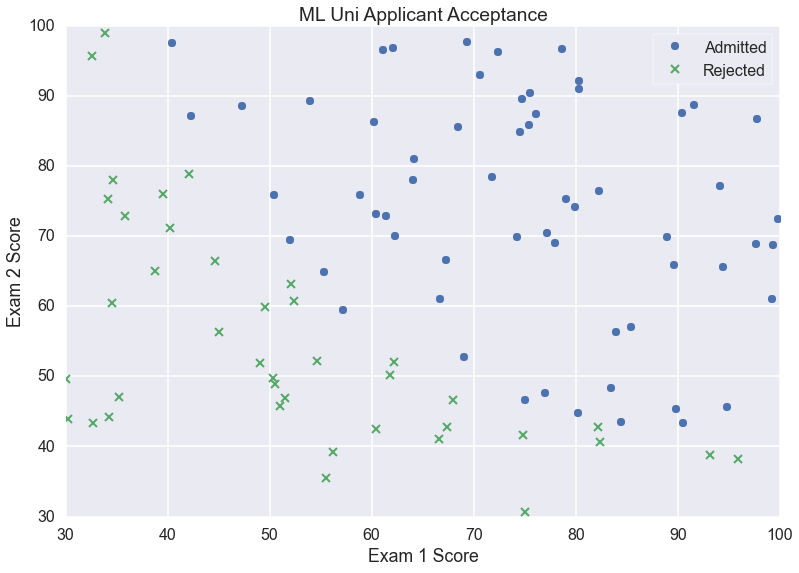

In [5]:
fig, ax = plt.subplots()
ax.plot(data[data['admittance'] == 1]['exam1'], data[data['admittance'] == 1]['exam2'], 'o', ms=8.0)
ax.plot(data[data['admittance'] == 0]['exam1'], data[data['admittance'] == 0]['exam2'], 'x', mew=2, ms=8.0)
ax.set_title('ML Uni Applicant Acceptance')
ax.legend(['Admitted', 'Rejected'], loc='upper right', frameon=True)
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
plt.show()

From the above plot we can see that the data has a clear boundary, and logit can indeed be used to model the data. The next step will be to determine what function can be best suited to provide us with a method to predict an applicants acceptance to ML Uni.

## The Hypothesis Function

The primary goal of our hypothesis is to predict an applicants likeihood of getting in to ML Uni. given their entrance grades. In other words, it should return a number between 0 and 1 repesenting the likelihood of accepted.

$$ 0 \leq h_{\theta}(x) \leq 1 $$

The commonly used function for this is the Sigmoid function:
$$ g(z) = \frac{1}{1+e^z} $$


## Visualizing the Sigmoid Function
A plot of the sigmoid function will better serve to illustrate why the sigmoid function is a good choice for this problem.

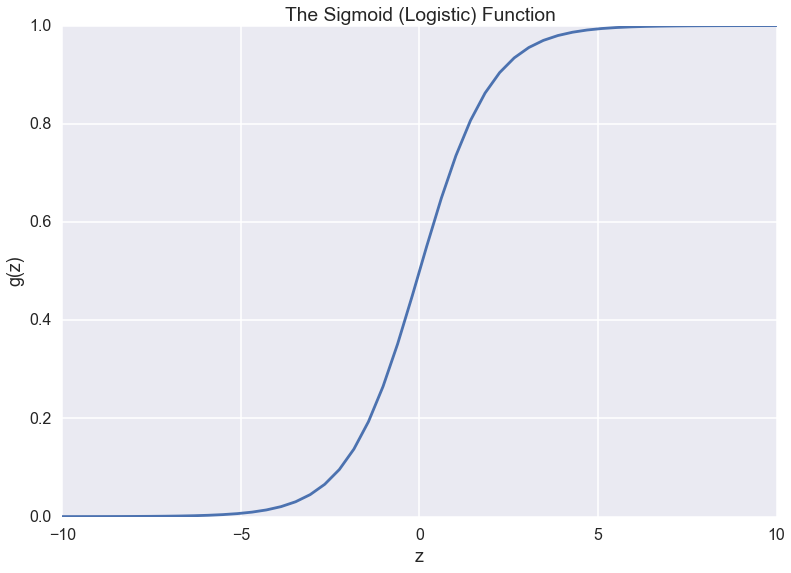

In [6]:
# The sigmoid function
sigmoid = lambda x: 1/(1+np.exp(-x))

x=np.linspace(-10, 10, 50)

# The plot
fig, ax = plt.subplots()
ax.plot(x, [sigmoid(i) for i in x])
ax.set_title('The Sigmoid (Logistic) Function')
ax.set_xlabel('z')
ax.set_ylabel('g(z)')

From the plot we can see that the sigmoid function asymptotes quickly about 0, and the co-domain spans the interval (0,1). Thus we can interpret the output of the sigmoid function as a probability.

As with linear regression the sigmoid function will be parameterized by a linear function of the form:

$$ \theta x = \theta_0 x_1 + \theta_1 x_1 + \dotsc + \theta_{n-1} x_{n-1} + \theta_n x_n $$

$$ h_{\theta}(x) = \frac{1}{1+e^{-\theta x}} $$


## The Cost Function for Logistic Regression
Now that the hypothesis has been determined, the next step is to determine a cost function. Unlike linear regression the squared error cost function cannot be used due to non-convexity that occurs when used with the sigmoid funciton. Due to this non-convexity the following cost function is used for logistic regression:
$$
Cost(h_{\theta}(\vec{x^{(i)})}) = \left\{
        \begin{array}{ll}
            -log(h_{\theta}(x^{(i)})) & \quad \text{if} \ y = 1 \\
            -log(1-h_{\theta}(x^{(i)})) & \quad \text{if} \ y = 0
        \end{array}
    \right.
$$

## Cost Plot: Case where the Applicant is Accepted (y = 1)
As before a plot will serve to illustrate how the cost function minimizes the parameters for the hypothesis. The first plot of the cost function will be for the case where the target is one (y = 1). This represents the case where the applicant is accepted.

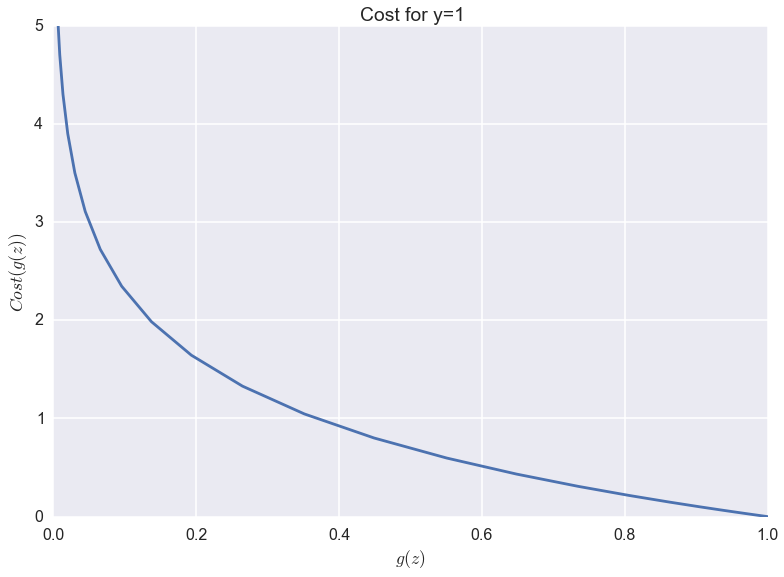

In [7]:
# The sigmoid function
cost_label_one = lambda z: -np.log(z)

# The plot
ax2 = plt.subplot()
ax2.plot([sigmoid(i) for i in x], [cost_label_one(sigmoid(i)) for i in x])
ax2.set_title(r'Cost for y=1')
ax2.set_xlabel(r'$g(z)$')
ax2.set_ylabel(r'$Cost(g(z))$')
ax2.set_xlim([0,1])
ax2.set_ylim([0,5])
plt.show()

We can see that the cost function for y=1 has the desired behavior of increasing the cost when the prediction nears zero, and decreases it when it approaches one, the target prediction. 

## Cost Plot: Case where the Applicant is Not Accepted (y = 0)

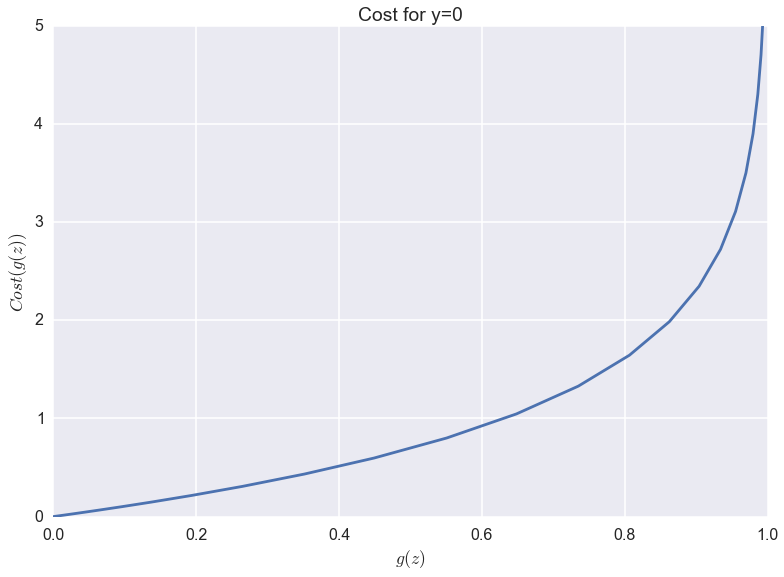

In [8]:
# The sigmoid function
cost_label_zero = lambda z: -np.log(1-z)


# The plot
ax2 = plt.subplot()

ax2.plot([sigmoid(i) for i in x], [cost_label_zero(sigmoid(i)) for i in x])
ax2.set_title(r'Cost for y=0')
ax2.set_xlabel(r'$g(z)$')
ax2.set_ylabel(r'$Cost(g(z))$')
ax2.set_xlim([0,1])
ax2.set_ylim([0,5])
plt.show()

We can see that the cost function for y=0 increasing the cost when the prediction nears one, and decreases it when it approaches zero, as expected. 

## Preparing the Cost Function for Minimization
Now that the hypothesis and cost function have been determined, the next few steps will be to prepare them for the minimization process. 

### Alternate Representation of the Cost Function
Below is an simpler, yet equivalent, representation of the piecewise cost function.

$$
J(\theta) = \frac{1}{m} \sum_{i = 1}^{m}{\Bigg[y^{(i)}log\big(h_{\theta} (x^{(i)})\big) + (1-y^{(i)})log\big(1-h_{\theta}(x^{(i)})\big)\Bigg]}
$$

As with linear regression, to facilitate computation, the cost function will be tranformed to an iquivalent matrix expression.


$$
J(\theta) = \frac{1}{m}\sum_{i = 1}^m\bigg[ -y \cdot log(g(X\theta)) -(1-y) \cdot log(1-g(X\theta))\bigg]
$$

### Gradient for the Minimization Process
In this implementation a [scipy minimization function](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.minimize.html) will be used to find the optimal parameters for the hypothesis function. This minimization function will be provided a reference a jacobian gradient function that will return both the cost and the a gradient. It's worth noting that the gradient is nearly identical to the left most term used in the theta update calculation for linear regression.

Below is the gradient equation in matrix form.

$$ gradient = \frac{1}{m}X^{T}(X \theta - y) $$

## Minimizing the Cost Function


### Preprocessing
To minimize the cost function the training data must be extracted into the design matrix (X), and target vector (y). Also the initial parameters (t) are chosen for the minization function.

In [9]:
m = len(data['exam1'])
X = np.array([np.ones(m), data['exam1'].values, data['exam2'].values]).T
y = np.array([data['admittance'].values]).reshape(m,1)
t = np.array([1.0, 1.0, 1.0])

### Defining the gradient and cost function for minimization

The numpy minimization function will be provided with a jacobian gradient to compute the cost and gradient. The definition of which is below.

In [10]:
def jacobian_gradient(theta, X, y):
    """ Calculate and return the cost function and gradient for the given thetas.
    
    Args:
        theta (numpy 1-D ndarray): Learning parameters
        X (numpy ndarray): Design Matrix
        y (numpy 1-D ndarray): Target vector
        
    Returns:
        tuple (float, numpy 1-D ndarray): The calculated cost, and gradient.
    """
    m, n = X.shape

    # Note: The min function flattens the first argument passed to the gradient (theta),
    #       yet our calculations require that thata be a column vector. To work around
    #       this the theta 1-D (n, ) vector is reshaped into a column vector (n, 1).
    t = theta.reshape(n,1)
    
    h = 1.0/(1.0 + np.exp(- X.dot(t)))
               
    cost = ((-y)*np.log(h) - (1-y)*np.log(1-h)).sum()/m
    gradient = X.T.dot(h - y) / m
    
    # Note: The minimization function requires that the gradient function returned be
    #       a 1-D array. To satisfy this requirement the gradient is flattened into a 
    #       1-D array.
    return (cost, gradient.flatten())

### Running the Minimization Function
With the jacobian gradient defined all that remains is to call the minimization function with the required parameters:
- jacobian_gradient: Function which in each iteration of the minimization proccess to calculate the cost and gradient.
- x0=t: The inital parameters used in the minimization process
- method=BFGS: The chosen minimization algorithm (Broyden–Fletcher–Goldfarb–Shanno)
- jac=True: Flag indicating that the jacobian gradientwill return both the cost and the gradient.
- args=(X,y): The second and third parameters passed to the jacobian gradient function (Note: x0 is the first param).

In [11]:
# Note: x0 must be a 1-D array.
results = opt.minimize(jacobian_gradient, x0=t, method='BFGS', jac=True, args=(X, y))

### Minimization Results
The minimization function returns an OptimizedResult object, which contains several attributes relating to the minimization process. The two relevant in this example are:

- success: True if the optimizer completed successfully, otherwise False.
- x: The optimized parameters.

In [12]:
results

  message: 'Optimization terminated successfully.'
      fun: 0.2034977015895529
     nfev: 67
        x: array([-25.16131376,   0.20623151,   0.20147148])
 hess_inv: array([[  2.80828345e+03,  -2.19770831e+01,  -2.31843128e+01],
       [ -2.19770831e+01,   1.85866635e-01,   1.69146733e-01],
       [ -2.31843128e+01,   1.69146733e-01,   2.06301018e-01]])
  success: True
      jac: array([  9.71782335e-10,  -1.67659643e-06,   1.04965204e-06])
     njev: 67
   status: 0

## Plotting the Decision Boundary

A contour plot will be used to visualze the output of the prediction function with the optimal parameters in place. This will give us a better idea of the likelihood distribution across various grades.

In [13]:
# Prediction function used to plot the hypothesis
@np.vectorize
def predict(x1, x2, t0, t1, t2):
    return 1.0/(1.0 + np.exp(-(t0 + t1*x1 + t2*x2)))

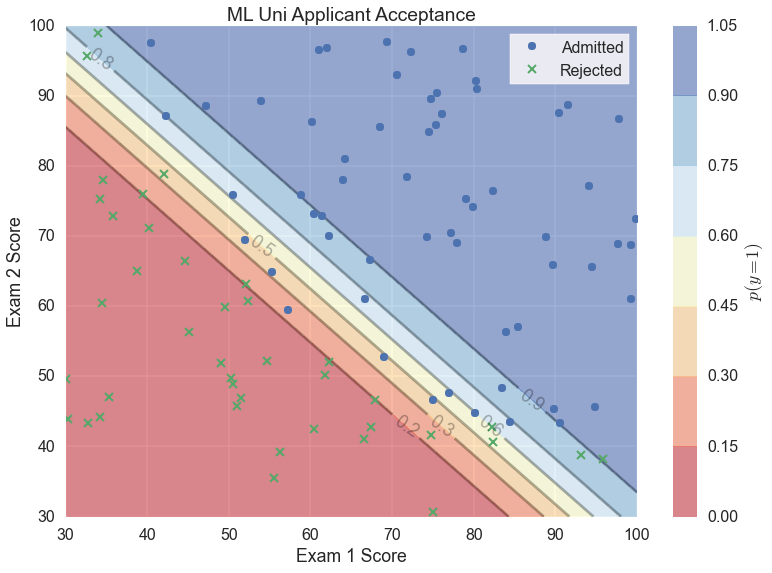

In [14]:
x_min, x_max = 30, 100
y_min, y_max = 30, 100

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))

theta = []
for i, t in enumerate(results.x):
    theta.append(np.empty((xx.shape[0], xx.shape[1])))
    theta[i].fill(t)

z = predict(xx, yy, theta[0], theta[1], theta[2])
z = z.reshape(xx.shape)

ax = plt.gca()
ax.plot(data[data['admittance'] == 1]['exam1'], data[data['admittance'] == 1]['exam2'], 'o', ms=8.0)
ax.plot(data[data['admittance'] == 0]['exam1'], data[data['admittance'] == 0]['exam2'], 'x', mew=2, ms=8.0)
ax.set_title('ML Uni Applicant Acceptance')

c = ax.contourf(xx, yy, z, cmap='RdYlBu', alpha=0.5)
c1 = ax.contour(xx, yy, z, colors='black', alpha=0.30)
plt.clabel(c1, fmt='%2.1f', fontsize=18, inline=True)
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
ax.legend(['Admitted', 'Rejected'], loc='upper right', frameon=True)

f = plt.gcf()
ax_c = f.colorbar(c)
ax_c.set_label("$p(y = 1)$")

plt.show()

The dicision boundary is along the 0.5 line in the above plot. As expected a majority of the accepted applicates lie this boundary, and a majority of the rejected applicates lie below. Also the likelihood rapidly converges to near 1 above the boundary, and converges to near 0 below. 

##Using Scikit-Learn for Logistic Regression

In practice machine learning libraries are used to implement logistic regression. In this case I will use logistic regression to reduce the above stepts to two lines of code.

In [15]:
logreg = linear_model.LogisticRegression(C=1.0)
logreg.fit(X[:,1:3], y.flatten())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

## Plotting the Decision Boundary

In [16]:
result = np.array([logreg.intercept_[0], logreg.coef_[0][0], logreg.coef_[0][1]])
results

  message: 'Optimization terminated successfully.'
      fun: 0.2034977015895529
     nfev: 67
        x: array([-25.16131376,   0.20623151,   0.20147148])
 hess_inv: array([[  2.80828345e+03,  -2.19770831e+01,  -2.31843128e+01],
       [ -2.19770831e+01,   1.85866635e-01,   1.69146733e-01],
       [ -2.31843128e+01,   1.69146733e-01,   2.06301018e-01]])
  success: True
      jac: array([  9.71782335e-10,  -1.67659643e-06,   1.04965204e-06])
     njev: 67
   status: 0

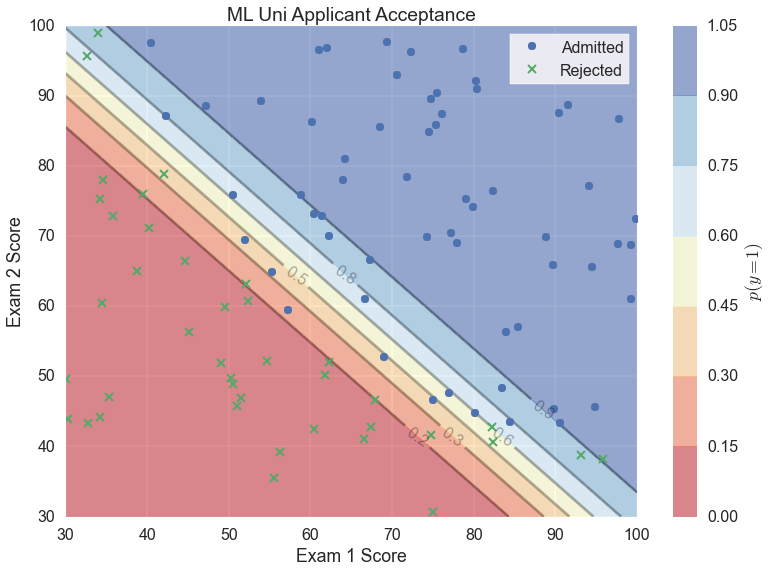

In [17]:
x_min, x_max = 30, 100
y_min, y_max = 30, 100

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))

theta = []
for i, t in enumerate(results.x):
    theta.append(np.empty((xx.shape[0], xx.shape[1])))
    theta[i].fill(t)

z = predict(xx, yy, theta[0], theta[1], theta[2])
z = z.reshape(xx.shape)

ax = plt.gca()
ax.plot(data[data['admittance'] == 1]['exam1'], data[data['admittance'] == 1]['exam2'], 'o', ms=8.0)
ax.plot(data[data['admittance'] == 0]['exam1'], data[data['admittance'] == 0]['exam2'], 'x', mew=2, ms=8.0)
ax.set_title('ML Uni Applicant Acceptance')
c = ax.contourf(xx, yy, z, cmap='RdYlBu', alpha=0.5)
c1 = ax.contour(xx, yy, z, colors='black', alpha=0.30, inline=True)
plt.clabel(c1, fmt='%2.1f', fontsize=16)
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
ax.legend(['Admitted', 'Rejected'], loc='upper right', frameon=True)

f = plt.gcf()
ax_c = f.colorbar(c)
ax_c.set_label("$p(y = 1)$")

plt.show()

The results are nearly identical, with a fraction of the work.

In the next post I will explore regularizing logistic regression.